## Y3 spetroscopic systematics dv test

In [16]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter

plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles

In [17]:
NRANS = dict(LRG = 8, ELG_LOP = 10, QSO = 4, ELG_LOPnotqso = 10)
BOX_SIZES = dict(LRG = 7000, ELG_LOP = 9000, QSO = 10000, ELG_LOPnotqso = 9000)

SHAM_ZRANGE = dict(LRG_1 = (np.arange(0.4,1.01,0.1), np.arange(0.5,1.11,0.1)),
                   LRG_LSS = ([0.4,0.6,0.8], [0.6,0.8,1.1]),
                   ELG_1 = (np.arange(0.8,1.51,0.1), np.arange(0.9,1.61,0.1)),
                   ELG_LSS = ([0.8,1.1,1.3], [1.1,1.3,1.6]),
                   QSO_1 = (np.arange(0.8,2.0,0.1), np.arange(0.9,2.1,0.1)),
                   QSO_LSS = ([0.8, 1.1, 1.4, 1.7],[1.1, 1.4, 1.7, 2.1 ])
                   )

EZ_ZRANGE = dict(LRG = [(0.4, 0.6), (0.6, 0.8), (0.8, 1.1)], 
                 ELG_LOP = [(0.8, 1.1), (1.1, 1.6)],
                 ELG_LOPnotqso = [(0.8, 1.1), (1.1, 1.6)],
                 QSO = [(0.8, 2.1)]
                )

JN_ZRANGE = dict(LRG = [(0.4, 0.6), (0.6, 0.8), (0.8, 1.1)], 
                 ELG_LOPnotqso = [(0.8, 1.1), (1.1, 1.3), (1.3, 1.6)],
                 QSO = [(0.8, 1.1), (1.1, 1.4), (1.4, 1.7), (1.7, 2.1)]
                )

SHAM_LABEL = dict(LRG_1 = ('LRG zbin=0.1'),
                   LRG_LSS = ('LRG zbin=LSS'),
                   ELG_1 = ('ELG zbin=z0.1'),
                   ELG_LSS = ('ELG zbin=LSS'),
                   QSO_1 = ('QSO zbin=z0.1'),
                   QSO_LSS = ('QSO zbin=LSS'),)


def matching_redshifts(tracer1, tracer2, REDSHIFTS, SHAM_ZRANGE=SHAM_ZRANGE):
    results = []
    for zmin, zmax in zip(SHAM_ZRANGE[tracer1][0], SHAM_ZRANGE[tracer1][1]):
        for redshift in REDSHIFTS[tracer2]:
            if redshift[0] <= zmin and redshift[1] >= zmax:
                results.append((zmin, zmax, redshift))
                break
    return results


In [ ]:
def bins(statistics):
    if statistics == 'xi':
        binning   = 4
        rmin      = 20
        rmax      = 200
        lenr      = 45
        return (rmin, rmax, binning, lenr)
    elif statistics == 'pk':
        kmin     = 0.0
        kmax     = 0.401
        binning  = 0.005
        lenk = 80
        return (kmin, kmax, binning, lenk)
    elif statistics == 'mpslog':
        smin      = 0.20
        smax      = 30
        return (smin, smax, 0, 0)
    elif statistics == 'wp':
        pmin = 0.20
        pmax = 30
        return (pmin, pmax, 0, 0)

def load_errors(error, tracer, zmin, zmax, ):

    if error == 'Y1_EZmocks_xi':
        (rmin, rmax, binning, lenr) = bins('xi')
        ez_error_dirs = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock{{}}/xi/smu'
        ez_error_fn = ez_error_dirs+f'/allcounts_{tracer}_GCcomb_z{zmin:.1f}-{zmax:.1f}_default_FKP_lin_nran{NRANS[tracer]}_njack0_split20_thetacut0.05.npy'
        ez_xi0 = []
        ez_xi2 = []
        for i in range(10):
            result = TwoPointCorrelationFunction.load(ez_error_fn.format(i+1))
            result = result[::binning,::]
            result.select((rmin, rmax))
            s,xi = project_to_multipoles(result, ells=[0,2])
            ez_xi0.append(xi[0])
            ez_xi2.append(xi[1])
        ez_xi_y1_error = [np.std(ez_xi0, axis=0), np.std(ez_xi2, axis=0)]
        error = ez_xi_y1_error

    elif error == 'Y1_EZmocks_pk':
        (kmin, kmax, binning, lenk) = bins('pk')
        ez_error_dirs = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock{{}}/pk'
        ez_error_fn = ez_error_dirs+f'/pkpoles_{tracer}_GCcomb_z{zmin:.1f}-{zmax:.1f}_default_FKP_lin_nran{NRANS[tracer]}_cellsize6_boxsize{BOX_SIZES[tracer]}.npy'
        ez_pk0 = []
        ez_pk2 = []
        for i in range(10):
            result = PowerSpectrumMultipoles.load(ez_error_fn.format(i+1))
            result = result.select((kmin,kmax,binning))
            pkl = np.real(result.get_power())
            k = result.k
            ez_pk0.append(pkl[0])
            ez_pk2.append(pkl[1])
        ez_pk_y1_error = [np.std(ez_pk0, axis=0), np.std(ez_pk2, axis=0)]
        error = ez_pk_y1_error

    elif error == 'Y1_analytical_xi':
        (rmin, rmax, binning, lenr) = bins('xi')
        analytical_cov= np.loadtxt(f"/global/cfs/projectdirs/desi/users/mrash/RascalC/Y1/unblinded/v1.5/xi024_{tracer}_GCcomb_{zmin}_{zmax}_default_FKP_lin4_s20-200_cov_RascalC_rescaled.txt")
        analytical_error = np.sqrt(np.diag(analytical_cov))
        analytical_xi_y1_error = [analytical_error[:lenr], analytical_error[lenr:2*lenr]]
        error = analytical_xi_y1_error
    
    elif error == 'Y1_analytical_pk':
        (kmin, kmax, binning, lenk) = bins('pk')
        analytical_cov= np.loadtxt(f"/global/cfs/projectdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/v0.6/blinded/pk/covariances/cov_gaussian_pre_ELG_LOPnotqso_GCcomb_{zmin}_{zmax}_default_FKP_lin.txt")
        analytical_error = np.sqrt(np.diag(analytical_cov))
        analytical_pk_y1_error = [analytical_error[:lenk], analytical_error[lenk:2*lenk]]
        error = analytical_pk_y1_error

    elif error == 'Y1_jacknife_mpslog':
        (smin, smax, binning, lens) = bins('mpslog')
        # print(f'SHAM z{sham_zmin:.1f}, z{sham_zmax:.1f}', f'EZmocks z{ez_zmin:.1f}, z{ez_zmax:.1f}')
        JN_dirs = '/global/cfs/cdirs/desi/users/arocher/Y1/v1.5pip/smu/'
        JN_fns = JN_dirs+f'allcounts_{tracer}_GCcomb_{zmin:.1f}_{zmax:.1f}_pip_angular_bitwise_log_njack128_nran4_split20.npy'
        result = TwoPointCorrelationFunction.load(JN_fns)
        result.select((smin, smax))
        s,xi,cov = project_to_multipoles(result, ells=[0,2], return_cov=True)
        error_bar = np.sqrt(np.diag(cov))
        jacknife_mpslog_y1_error = [error_bar[:len(s)], error_bar[len(s):]]
        error = jacknife_mpslog_y1_error

    elif error == 'Y1_analytical_mpslog':
        (smin, smax, binning, lens) = bins('mpslog')
        if zmin == 1.3 or zmax==1.3:
            analytical_covname = f"/global/cfs/cdirs/desi/survey/catalogs/edav1/xi/sv3/smu/allcounts_ELG_NScomb_1.1_1.6_default_angular_bitwise_FKP_log_njack128_nran18_split20.npy"
        else:
            analytical_covname = f"/global/cfs/cdirs/desi/survey/catalogs/edav1/xi/sv3/smu/allcounts_ELG_NScomb_0.8_1.1_default_angular_bitwise_FKP_log_njack128_nran18_split20.npy"
        result = TwoPointCorrelationFunction.load(analytical_covname)
        result.select((smin, smax))
        s,xi,cov = project_to_multipoles(result, ells=[0,2], return_cov=True)
        error_bar = np.sqrt(np.diag(cov))
        analytical_mpslog_y1_error = [error_bar[:len(s)], error_bar[len(s):]]
        error = analytical_mpslog_y1_error

    elif error == 'Y3_mocks_mpslog':
        (smin, smax, binning, lens) = bins('mpslog')
        analytical_covname=f"/pscratch/sd/j/jiaxi/Y3/LSS/kibo-v1/LSScats/v0.1/PIP/smu/allcounts_{tracer}_GCcomb_{zmin}_{zmax}_pip_angular_bitwise_log_njack128_nran4_split20.npy"
        result = TwoPointCorrelationFunction.load(analytical_covname)
        result.select((smin, smax))
        s,xi,cov = project_to_multipoles(result, ells=[0,2], return_cov=True)
        error_bar = np.sqrt(np.diag(cov))
        mocks_mpslog_y3_error = [error_bar[:len(s)], error_bar[len(s):]]
        error = mocks_mpslog_y3_error

    elif error == 'Y3_mocks_wp':
        (pmin, pmax, binning, lenp) = bins('wp')
        analytical_covname=f"/pscratch/sd/j/jiaxi/Y3/LSS/kibo-v1/LSScats/v0.1/PIP/rppi/allcounts_{tracer}_GCcomb_{zmin}_{zmax}_pip_angular_bitwise_log_njack128_nran4_split20.npy"
        result = TwoPointCorrelationFunction.load(analytical_covname)
        result.select((pmin, pmax))
        p,wp,cov = project_to_wp(result, return_cov=True)
        error_bar = np.sqrt(np.diag(cov))
        mocks_wp_y3_error = error_bar
        error = mocks_wp_y3_error
        
    return error

def load_EDR(statistics, tracer, zmin, zmax, sys_model):
    EDR_dir = '/global/cfs/projectdirs/desi/users/jiaxiyu/repeated_observations/EDR_vs_Y3/LSS-scripts_repeats/dv-test'

    if statistics == 'xi':
        (rmin, rmax, binning, lenr) = bins('xi')
        if sys_model == 'standard':
            EDR_fn = EDR_dir+'/mps_standard_zmin-zmax_vsmear_dv-dvmode.npy'
        else: 
            EDR_fn = EDR_dir+f'/mps_{tracer}_z{zmin:.1f}-{zmax:.1f}_vsmear_dv-{sys_model}.npy'
        result = TwoPointCorrelationFunction.load(EDR_fn)
        result = result[::binning,::]
        result.select((rmin, rmax))
        s,xi = project_to_multipoles(result, ells=[0,2])
        return (s, xi)

    elif statistics == 'pk':
        (kmin, kmax, binning, lenk) = bins('pk')
        if sys_model == 'standard':
            EDR_fn = EDR_dir+'/pk_standard_zmin-zmax_vsmear_dv-dvmode.npy'
        else: 
            EDR_fn = EDR_dir+f'/pk_{tracer}_z{zmin:.1f}-{zmax:.1f}_vsmear_dv-{sys_model}.npy'
        result = PowerSpectrumMultipoles.load(EDR_fn)
        result = result.select((kmin,kmax,binning))
        pkl = np.real(result.get_power())
        k = result.kavg
        return (k, pkl)

    elif statistics == 'mpslog':
        (smin, smax, binning, lens) = bins('mpslog')
        if sys_model == 'standard':
            EDR_fn = EDR_dir+'/mpslog_standard_zmin-zmax_vsmear_dv-dvmode.npy'
        else: 
            EDR_fn = EDR_dir+f'/mpslog_{tracer}_z{zmin:.1f}-{zmax:.1f}_vsmear_dv-{sys_model}.npy'
        result = TwoPointCorrelationFunction.load(EDR_fn)
        result.select((smin, smax))
        s,mpslog = project_to_multipoles(result, ells=[0,2])
        return (s, mpslog)

    elif statistics == 'wp':
        (pmin, pmax, binning, lenp) = bins('wp')
        if sys_model == 'standard':
            EDR_fn = EDR_dir+'/wplog_standard_zmin-zmax_vsmear_dv-dvmode.npy'
        else: 
            EDR_fn = EDR_dir+f'/wplog_{tracer}_z{zmin:.1f}-{zmax:.1f}_vsmear_dv-{sys_model}.npy'
        result = TwoPointCorrelationFunction.load(EDR_fn)
        result.select((pmin, pmax))
        p,wp = project_to_wp(result)
        return (p, wp)
    

Text(0, 0.5, '$\\Delta P_2/\\sigma_{Y1} $')

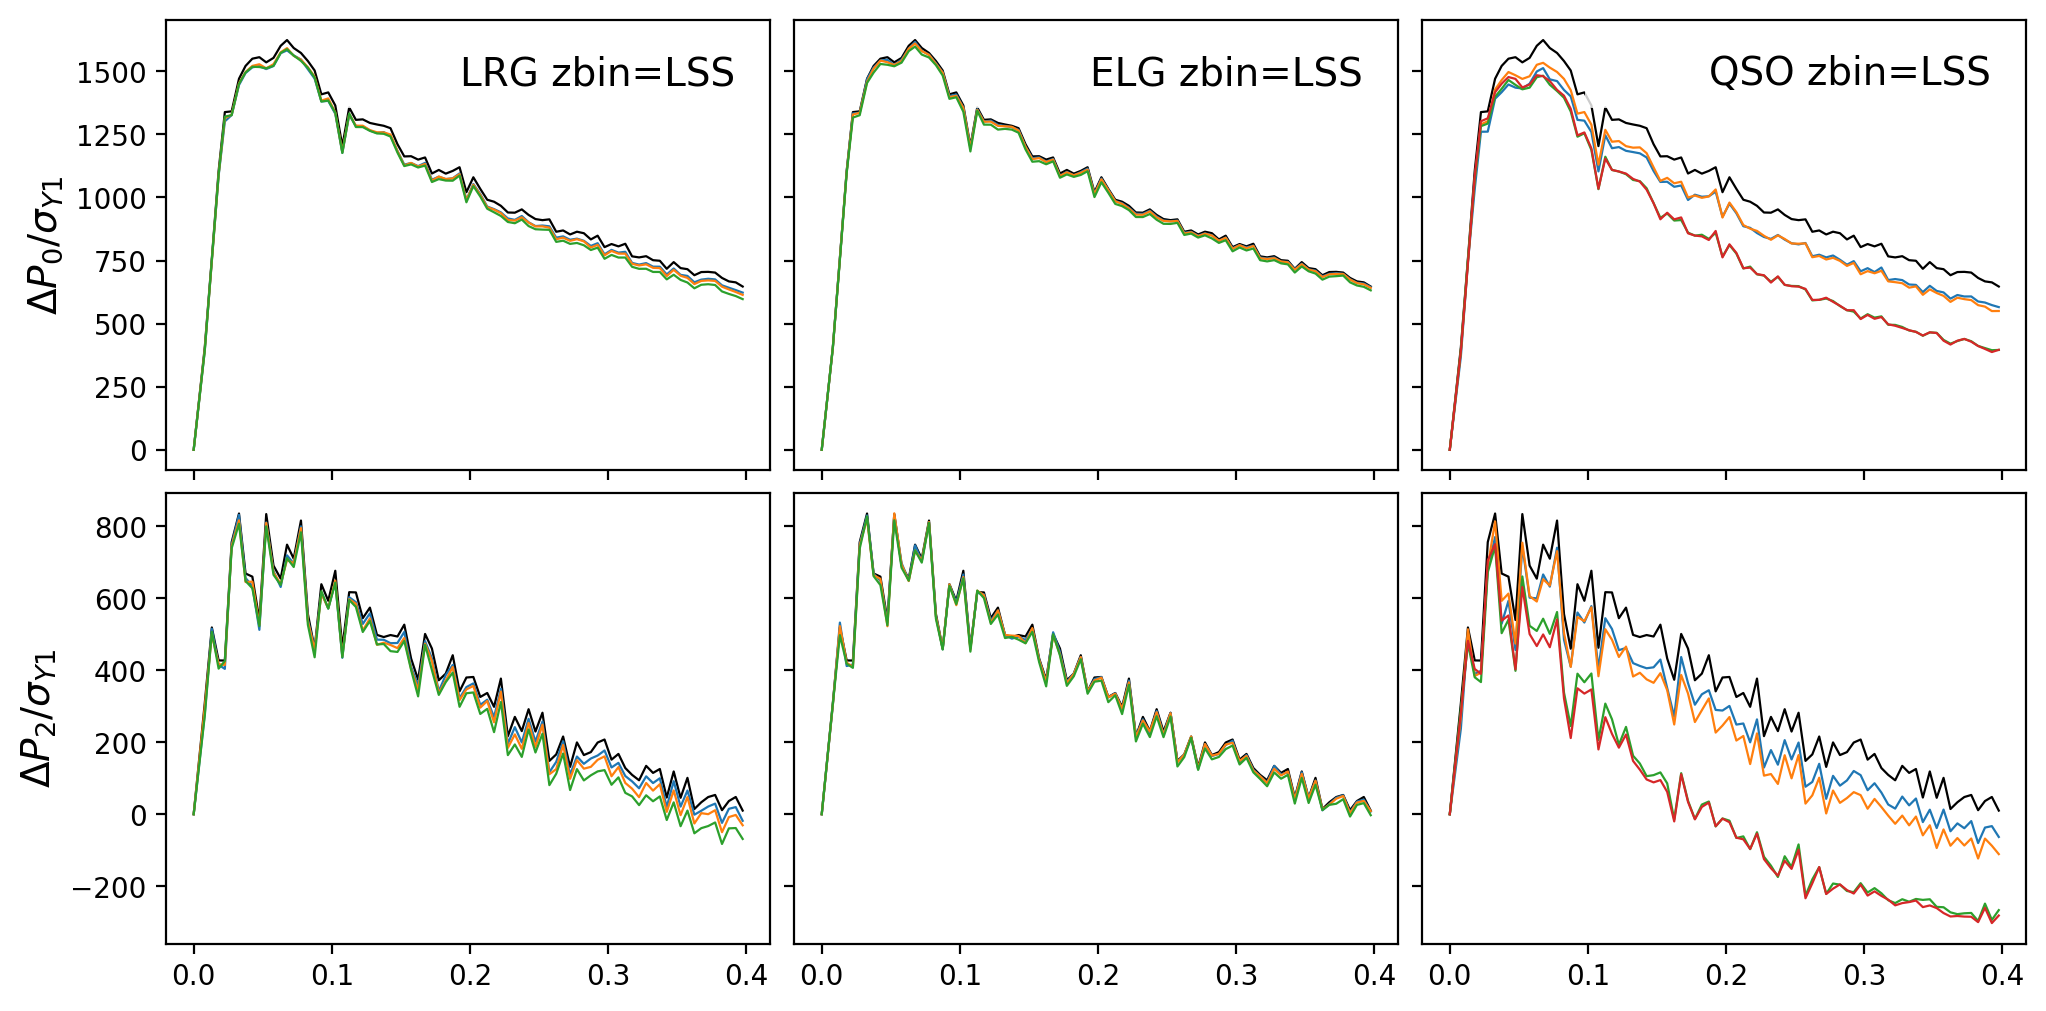

In [ ]:
############# power spectrum ('pk') here #############
compare = 'y3_HOD_ref' # dv_model, dv_wo, y1_elg_catas, y3_HOD_ref
error = 'Y1_EZmocks_pk' # Y1_EZmocks_pk, Y1_analytical_pk

(kmin, kmax, binning, lenk) = bins('pk')

if compare in ['dv_model', 'dv_wo']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']
    fig, ax = plt.subplots(2,6, figsize = (16,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y1_elg_catas']:
    zcheck = ['ELG_LSS', 'ELG_LSS', 'ELG_1', 'ELG_1']
    fig, ax = plt.subplots(2,4, figsize = (12,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y3_HOD_ref']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS']
    fig, ax = plt.subplots(2,3, figsize = (12,6), sharex=True, sharey='row', gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05)

for z, Ztracer in enumerate(zcheck):
    if Ztracer == 'LRG_1' or Ztracer == 'LRG_LSS':
        EZtracer = SHAMtracer = tracer = 'LRG'
    if Ztracer == 'ELG_1' or Ztracer == 'ELG_LSS':
        EZtracer = 'ELG_LOP'; SHAMtracer = 'ELG'; tracer = 'ELG_LOPnotqso'
    if Ztracer == 'QSO_1' or Ztracer == 'QSO_LSS':
        EZtracer = SHAMtracer = tracer = 'QSO'
    label = SHAM_LABEL[Ztracer]
    # redshifts = matching_redshifts(Ztracer, tracer, JN_ZRANGE)
    redshifts = matching_redshifts(Ztracer, EZtracer, EZ_ZRANGE)
    for i, (sham_zmin,sham_zmax,(error_zmin, error_zmax)) in zip(range(len(redshifts)),redshifts):
        # proceed for errors
        if compare in ['dv_model', 'dv_wo', 'y3_HOD_ref']:
            pk_error =  load_errors(error, EZtracer, error_zmin, error_zmax)
            if compare == 'dv_model':
                sys_models = ['obs','model']
            elif compare == 'dv_wo' or compare == 'y3_HOD_ref':
                sys_models = ['standard', 'obs']
        elif compare in ['y1_elg_catas']:
            pk_error = load_errors('Y1_analytical_pk', 'ELG_LOPnotqso', error_zmin, error_zmax)
            sys_models = ['standard', 'obs_catasonly', 'model_catasonly']
        # proceed for EDR data
        for sys_model in sys_models:
            (k,pkl) = load_EDR('pk', SHAMtracer, sham_zmin, sham_zmax, sys_model)            
            if sys_model in ['obs','obs_catasonly']:
                pk_dv_obs = pkl
            if sys_model in ['model','model_catasonly']:
                pk_dv_model = pkl 
            if sys_model in ['standard']:
                pk_dv_standard = pkl
        # plot the figures
        for ell in range(2):
            if compare == 'dv_model':
                ax[ell][z].plot(k, (pk_dv_obs-pk_dv_model)[ell]/pk_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'dv_wo':
                ax[ell][z].plot(k, pk_dv_obs[ell]/pk_dv_standard[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'y3_HOD_ref':
                # ax[ell][z].plot(s, (xi_dv_obs-xi_dv_standard)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
                if i == 0:
                    ax[ell][z].plot(k, k*pk_dv_standard[ell], lw =0.8, label =f'standard {SHAMtracer}', ls = '-', color = f'black')
                ax[ell][z].plot(k, k*pk_dv_obs[ell], lw =0.8, label =f'dv {SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]', ls = '-', color = f'C{i}')
            elif compare == 'y1_elg_catas':
                if z==0 or z==2:
                    ax[ell][z].plot(k, (pk_dv_obs-pk_dv_standard)[ell]/pk_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
                if z==1 or z==3:
                    ax[ell][z].plot(k, (pk_dv_model-pk_dv_standard)[ell]/pk_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
    for i in range(2):
        # ax[i][z].fill_between(k, -1 , 1, color = '#98FB98', alpha=0.05)
        # ax[i][z].axhline(y=1, color = 'black', ls='--')
        # ax[i][z].axhline(y=-1, color = 'black', ls='--')
        # ax[i][z].axhline(y=0, color='black', lw=0.6)
        if i == 0:
            line= Line2D([0], [0], label=label, color='none', alpha=0)
            leg1 = ax[i][z].legend(handles=[line], loc=1)
            leg1.get_frame().set_linewidth(0.0)
        if z == 0 :
            ax[0][z].set_ylabel(r"$s^2*\xi_0$")
            ax[1][z].set_ylabel(r"$s^2*\xi_2$")
    ax[1][z].set_xlabel(r"$s$")

if compare in ['dv_model', 'dv_wo']:
    bbox_to_anchor = (1, 1.5)
    ax[1][5].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
    # ax[0][0].set_ylim([-3.5, 3.5])

if compare in ['y1_elg_catas']:
    ax[0][0].set_ylim([-4.0, 1.2])
    ax[0][0].set_xlim([0, 0.3])
    bbox_to_anchor = (1.0, 0.8)
    ax[1][3].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)

if compare in ['y3_HOD_ref']:
    bbox_to_anchor = (1.0, 1.5)
    ax[1][2].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)


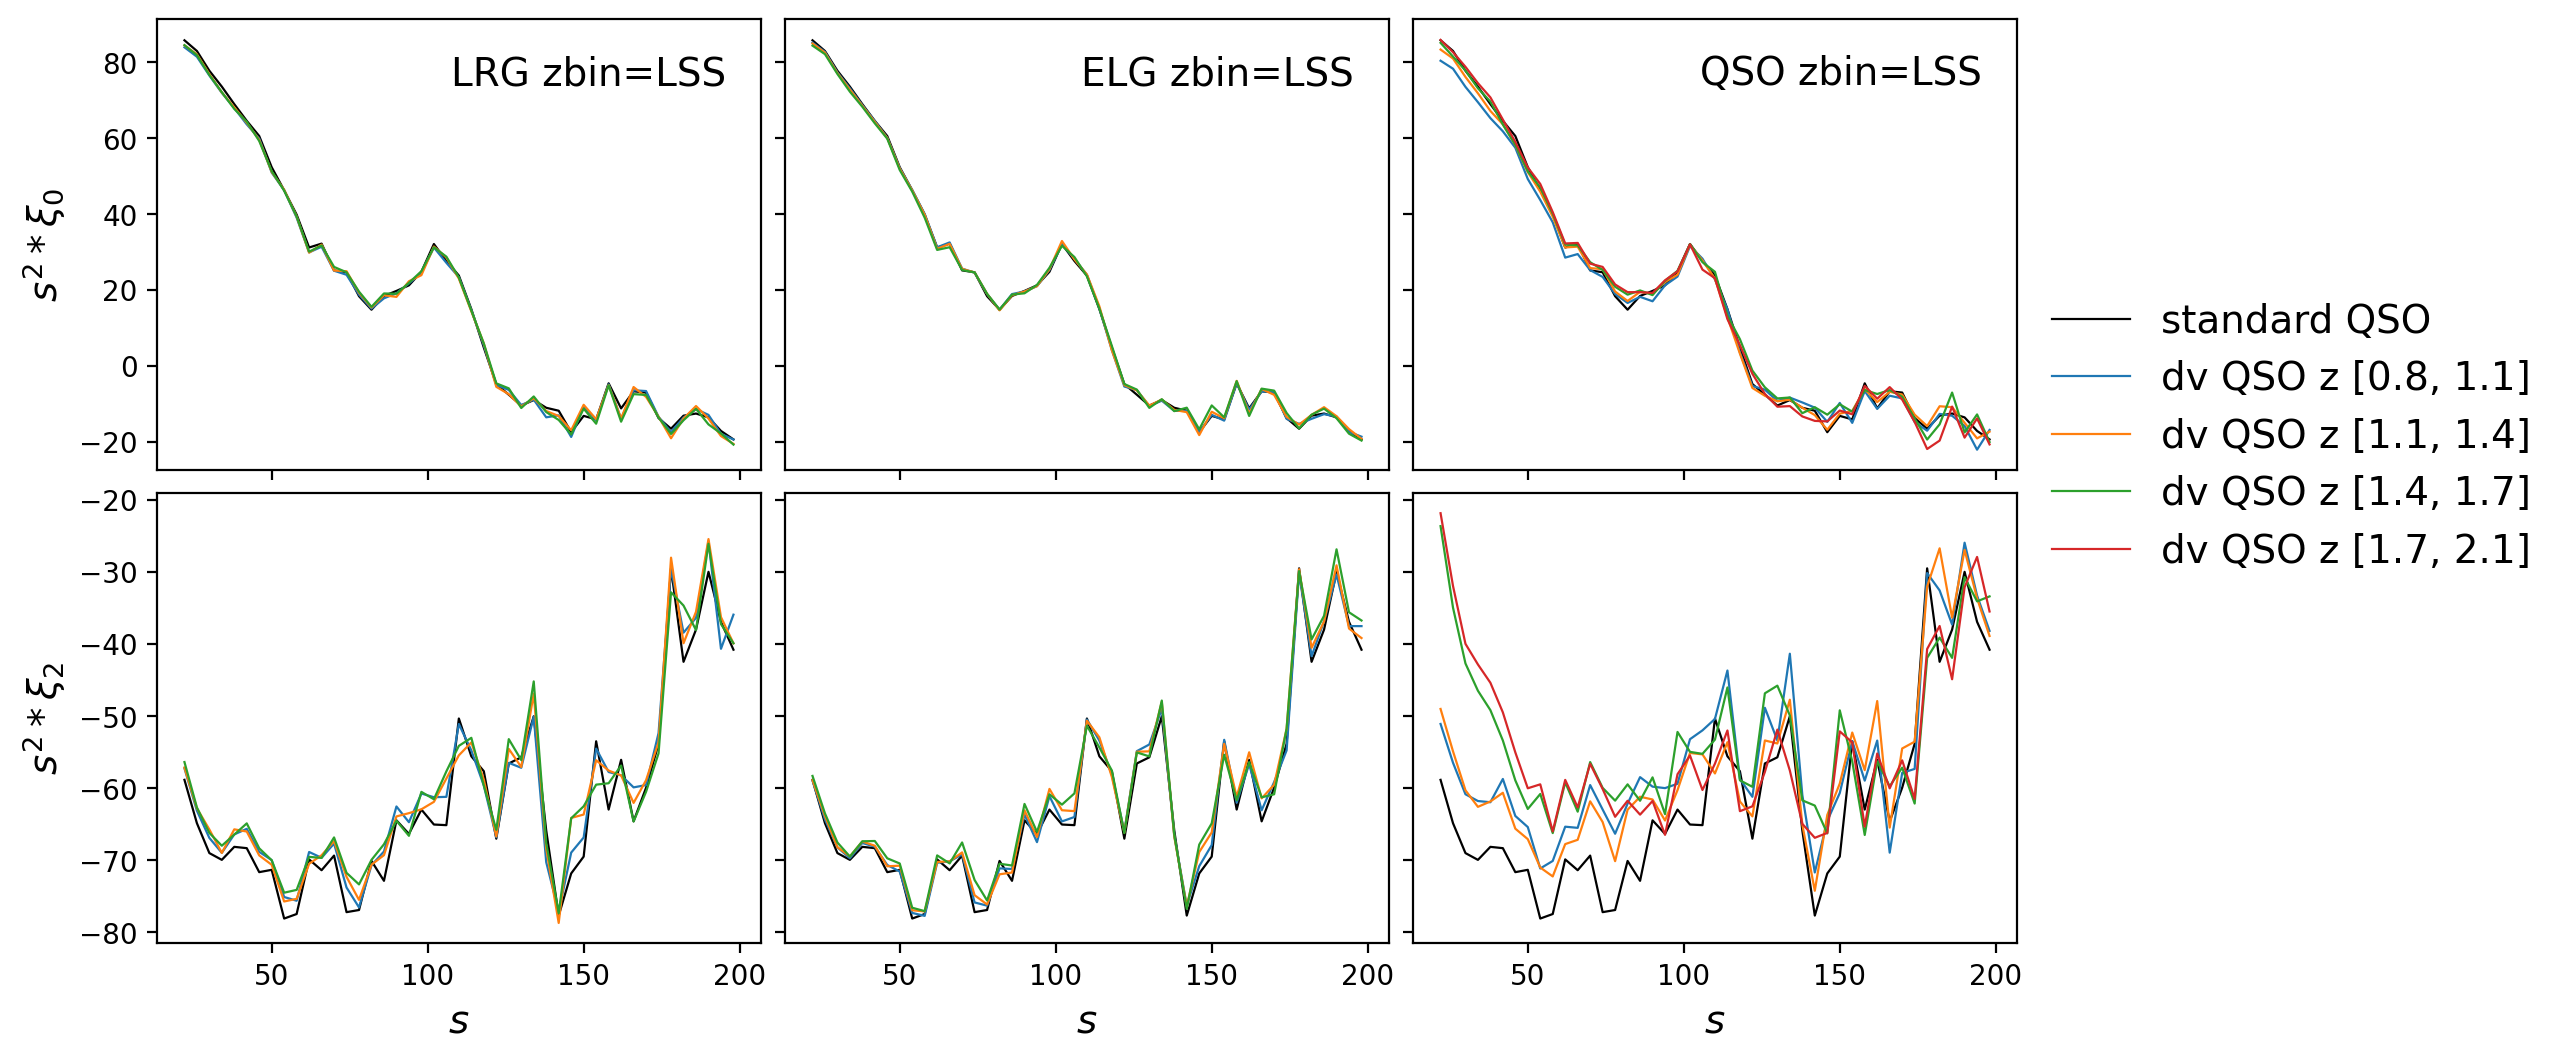

In [ ]:
############# 2pcf ('xi') here #############
compare = 'y3_HOD_ref' # dv_model, dv_wo, y1_elg_catas, y3_HOD_ref
error = 'Y1_EZmocks_xi' # Y1_EZmocks_xi, Y1_analytical_xi

(rmin, rmax, binning, lenr) = bins('xi')

if compare in ['dv_model', 'dv_wo']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']
    fig, ax = plt.subplots(2,6, figsize = (16,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y1_elg_catas']:
    zcheck = ['ELG_LSS', 'ELG_LSS', 'ELG_1', 'ELG_1']
    fig, ax = plt.subplots(2,4, figsize = (12,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y3_HOD_ref']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS']
    fig, ax = plt.subplots(2,3, figsize = (12,6), sharex=True, sharey='row', gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05)

# for z, Ztracer in enumerate(['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']):
for z, Ztracer in enumerate(zcheck):
    if Ztracer == 'LRG_1' or Ztracer == 'LRG_LSS':
        EZtracer = SHAMtracer = tracer = 'LRG'
    if Ztracer == 'ELG_1' or Ztracer == 'ELG_LSS':
        EZtracer = 'ELG_LOP'; SHAMtracer = 'ELG'; tracer = 'ELG_LOPnotqso'
    if Ztracer == 'QSO_1' or Ztracer == 'QSO_LSS':
        EZtracer = SHAMtracer = tracer = 'QSO'
    label = SHAM_LABEL[Ztracer]
    redshifts = matching_redshifts(Ztracer, EZtracer, EZ_ZRANGE)
    for i, (sham_zmin,sham_zmax,(error_zmin, error_zmax)) in zip(range(len(redshifts)),redshifts):
        # proceed for errors
        if compare in ['dv_model', 'dv_wo', 'y3_HOD_ref']:
            error_tracer = EZtracer if error == 'Y1_EZmocks_xi' else tracer
            xi_error =  load_errors(error, error_tracer, error_zmin, error_zmax)
            if compare == 'dv_model':
                sys_models = ['obs','model']
            elif compare == 'dv_wo' or  compare == 'y3_HOD_ref':
                sys_models = ['standard', 'obs']
        elif compare in ['y1_elg_catas']:
            xi_error = load_errors('Y1_analytical_xi', 'ELG_LOPnotqso', error_zmin, error_zmax)
            sys_models = ['standard', 'obs_catasonly', 'model_catasonly']
        # proceed for EDR data
        for sys_model in sys_models:
            (s,xi) = load_EDR('xi', SHAMtracer, sham_zmin, sham_zmax, sys_model)            
            if sys_model in ['obs','obs_catasonly']:
                xi_dv_obs = xi
            if sys_model in ['model','model_catasonly']:
                xi_dv_model = xi 
            if sys_model in ['standard']:
                xi_dv_standard = xi

        # plot the figures       
        for ell in range(2):
            if compare == 'dv_model':
                ax[ell][z].plot(s, (xi_dv_obs-xi_dv_model)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'dv_wo':
                ax[ell][z].plot(s, (xi_dv_obs-xi_dv_standard)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'y3_HOD_ref':
                # ax[ell][z].plot(s, (xi_dv_obs-xi_dv_standard)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
                if i == 0:
                    ax[ell][z].plot(s, s**2*xi_dv_standard[ell], lw =0.8, label =f'standard {SHAMtracer}', ls = '-', color = f'black')
                ax[ell][z].plot(s, s**2*xi_dv_obs[ell], lw =0.8, label =f'dv {SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]', ls = '-', color = f'C{i}')
            elif compare =='y1_elg_catas':
                if z == 0 or z==2:
                    ax[ell][z].plot(s, (xi_dv_obs-xi_dv_standard)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} obs dv z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
                if z == 1 or z==3:
                    ax[ell][z].plot(s, (xi_dv_model-xi_dv_standard)[ell]/xi_error[ell], lw =0.8, label =f'{SHAMtracer} model dv z [{sham_zmin:.1f}, {sham_zmax:.1f}]')

    for i in range(2):
        # ax[i][z].fill_between(s, -1 , 1, color = '#d1e7f7', alpha=0.3)
        # ax[i][z].axhline(y=1, color = 'black', ls='--')
        # ax[i][z].axhline(y=-1, color = 'black', ls='--')
        # ax[i][z].axhline(y=0, color='black', lw=0.6)
        if i == 0:
            line= Line2D([0], [0], label=label, color='none', alpha=0)
            leg1 = ax[i][z].legend(handles=[line], loc=1)
            leg1.get_frame().set_linewidth(0.0)
        # if z == 0 :
        #     ax[0][z].set_ylabel(r"$\Delta\xi_0/\sigma_{Y3} $")
        #     ax[1][z].set_ylabel(r"$\Delta\xi_2/\sigma_{Y3} $")
        if z == 0 :
            ax[0][z].set_ylabel(r"$s^2*\xi_0$")
            ax[1][z].set_ylabel(r"$s^2*\xi_2$")
    ax[1][z].set_xlabel(r"$s$")

if compare in ['dv_model', 'dv_wo']:
    bbox_to_anchor = (1, 1.5)
    ax[1][5].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
    # ax[0][0].set_ylim([-3.5, 3.5])

if compare in ['y1_elg_catas']:
    ax[0][0].set_ylim([-0.5, 0.5])
    ax[0][0].set_xlim([30, 200])
    bbox_to_anchor = (1, 1.5)
    ax[1][3].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)

if compare in ['y3_HOD_ref']:
    bbox_to_anchor = (1.0, 1.5)
    ax[1][2].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)

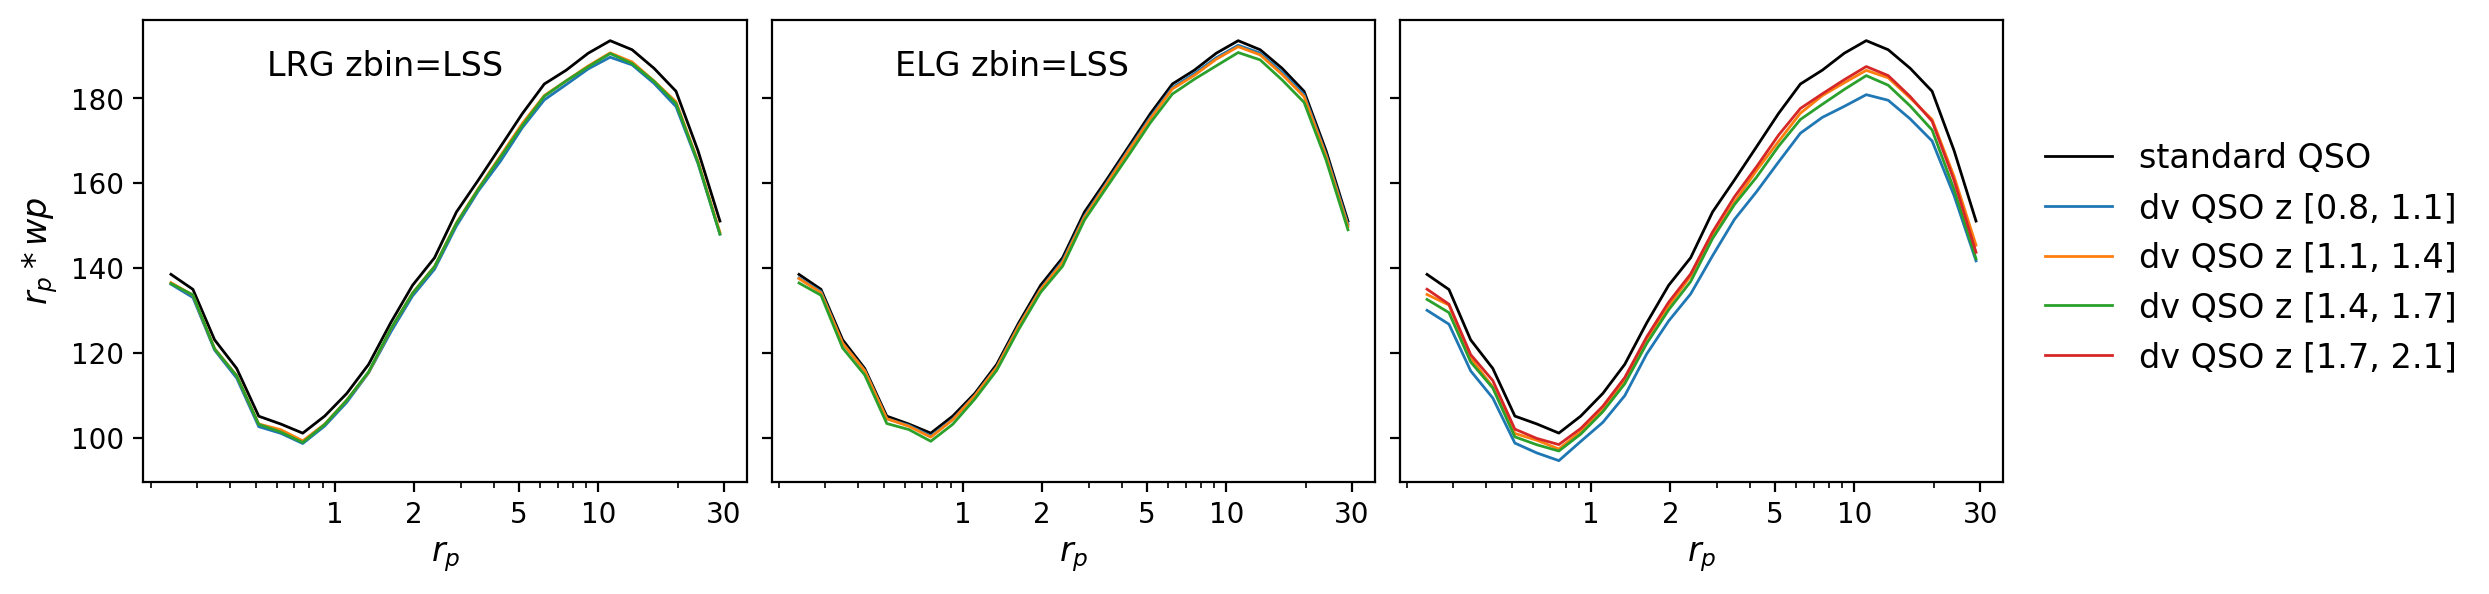

In [26]:
############# angular 2pcf (wp) here #############
compare = 'y3_HOD_ref' # dv_model, dv_wo, y3_HOD_ref
error = 'Y3_mocks_wp' # Y3_mocks_wp

(pmin, pmax, binning, lens) = bins('wp')

if compare in ['dv_model', 'dv_wo']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']
    fig, ax = plt.subplots(1,6, figsize = (16,3), sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0.04, hspace=0.05)

if compare in ['y3_HOD_ref']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS']
    fig, ax = plt.subplots(1,3, figsize = (12,3), sharex='row', sharey=True)
    fig.subplots_adjust(wspace=0.04, hspace=0.05)

# for z, Ztracer in enumerate(['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']):
for z, Ztracer in enumerate(zcheck):
    if Ztracer == 'LRG_1' or Ztracer == 'LRG_LSS':
        EZtracer = SHAMtracer = tracer = 'LRG'
    if Ztracer == 'ELG_1' or Ztracer == 'ELG_LSS':
        EZtracer = 'ELG_LOP'; SHAMtracer = 'ELG'; tracer = 'ELG_LOPnotqso'
    if Ztracer == 'QSO_1' or Ztracer == 'QSO_LSS':
        EZtracer = SHAMtracer = tracer = 'QSO'
    label = SHAM_LABEL[Ztracer]
    redshifts = matching_redshifts(Ztracer, tracer, JN_ZRANGE)
    for i, (sham_zmin,sham_zmax,(error_zmin, error_zmax)) in zip(range(len(redshifts)),redshifts):
        # proceed for errors
        if compare in ['dv_model', 'dv_wo', 'y3_HOD_ref']:
            wp_error =  load_errors(error, tracer, error_zmin, error_zmax)
            if compare == 'dv_model':
                sys_models = ['obs','model']
            elif compare == 'dv_wo' or compare == 'y3_HOD_ref':
                sys_models = ['standard', 'obs']
        # proceed for EDR data
        for sys_model in sys_models:
            (p, wp) = load_EDR('wp', SHAMtracer, sham_zmin, sham_zmax, sys_model)            
            if sys_model in ['obs','obs_catasonly']:
                wp_dv_obs = wp
            if sys_model in ['model','model_catasonly']:
                wp_dv_model = wp 
            if sys_model in ['standard']:
                wp_dv_standard = wp
        # plot the figures
        if compare == 'dv_model':
            ax[z].plot(p, (wp_dv_obs-wp_dv_model)/wp_error, lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
        elif compare == 'dv_wo':
            ax[z].plot(p, (wp_dv_obs-wp_dv_standard)/wp_error, lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
        elif compare == 'y3_HOD_ref':
            # ax[z].plot(p, (wp_dv_obs-wp_dv_standard)/wp_error, lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            if i==0:
                ax[z].plot(p, p*wp_dv_standard, lw =1.0, label =f'standard {SHAMtracer}', ls = '-', color = f'black')
            ax[z].plot(p, p*wp_dv_obs, lw =1.0, label =f'dv {SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]', ls = '-', color = f'C{i}')
            
    # ax[z].fill_between(p, -1 , 1, color = '#FFA07A', alpha=0.1)
    # ax[z].axhline(y=1, color = 'black', ls='--')
    # ax[z].axhline(y=-1, color = 'black', ls='--')
    # ax[z].axhline(y=0, color='black', lw=0.6)
    line= Line2D([0], [0], label=label, color='none', alpha=0)
    leg1 = ax[z].legend(handles=[line], loc=2)
    leg1.get_frame().set_linewidth(0.0)

    if z == 0:
        # ax[z].set_ylabel(r"$\Delta wp/\sigma_{Y3} $")
        ax[z].set_ylabel(r"$r_p*wp$")
        
    ax[z].set_xlabel(r"$r_p $")

if compare in ['dv_model', 'dv_wo']:
    bbox_to_anchor = (1, 1.0)
    ax[5].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)

if compare in ['y3_HOD_ref']:
    ax[0].set_xscale('log')
    bbox_to_anchor = (1.8, 0.8)
    ax[2].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
    # ax[0].set_xscale('log')
    for AX, axis in enumerate([ax[0].xaxis, ax[0].yaxis]):
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(NullFormatter())
        if AX == 0:  # Customize the x-axis ticks
            ax[0].set_xticks([1, 2, 5, 10, 30])


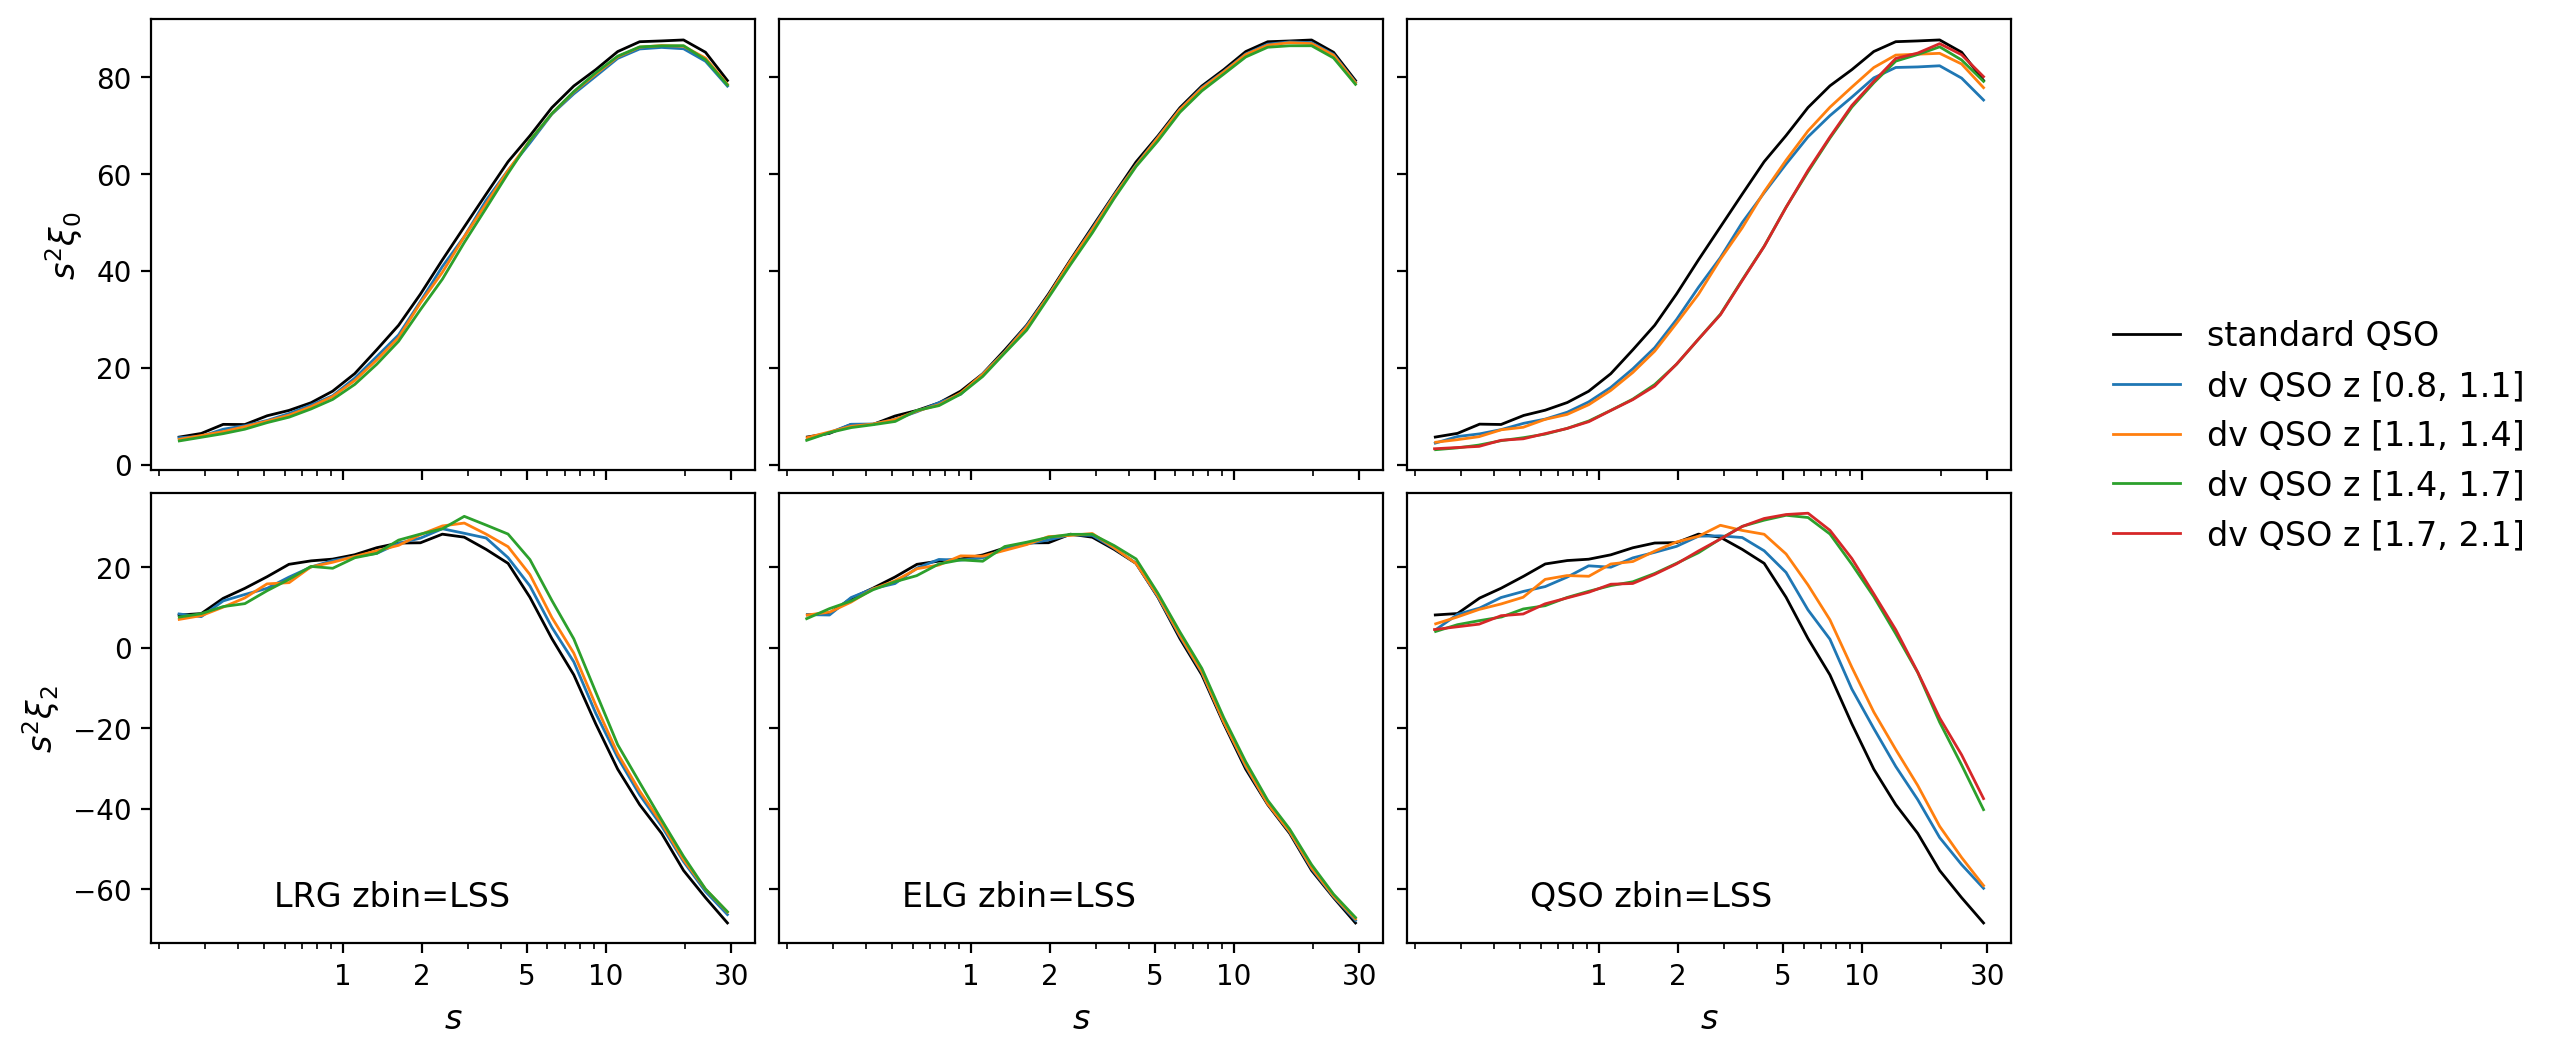

In [27]:
############# 2pcf log bin small scale (mpslog) here #############
compare = 'y3_HOD_ref' # dv_model, dv_wo, y1_elg_catas, y3_HOD
error = 'Y3_mocks_mpslog' # Y1_jacknife_mpslog, Y1_analytical_mpslog, Y3_mocks_mpslog

(smin, smax, binning, lens) = bins('mpslog')

if compare in ['dv_model', 'dv_wo']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']
    fig, ax = plt.subplots(2,6, figsize = (16,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y1_elg_catas']:
    zcheck = ['ELG_LSS', 'ELG_LSS', 'ELG_1', 'ELG_1']
    fig, ax = plt.subplots(2,4, figsize = (12,6), sharex=True, sharey=True, gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05) 

if compare in ['y3_HOD_ref']:
    zcheck = ['LRG_LSS', 'ELG_LSS', 'QSO_LSS']
    fig, ax = plt.subplots(2,3, figsize = (12,6), sharex=True, sharey='row', gridspec_kw={'height_ratios': [1, 1]})
    fig.subplots_adjust(wspace=0.04, hspace=0.05)

# for z, Ztracer in enumerate(['LRG_LSS', 'ELG_LSS', 'QSO_LSS', 'LRG_1', 'ELG_1', 'QSO_1']):
for z, Ztracer in enumerate(zcheck):
    if Ztracer == 'LRG_1' or Ztracer == 'LRG_LSS':
        EZtracer = SHAMtracer = tracer = 'LRG'
    if Ztracer == 'ELG_1' or Ztracer == 'ELG_LSS':
        EZtracer = 'ELG_LOP'; SHAMtracer = 'ELG'; tracer = 'ELG_LOPnotqso'
    if Ztracer == 'QSO_1' or Ztracer == 'QSO_LSS':
        EZtracer = SHAMtracer = tracer = 'QSO'
    label = SHAM_LABEL[Ztracer]
    redshifts = matching_redshifts(Ztracer, tracer, JN_ZRANGE)
    for i, (sham_zmin,sham_zmax,(error_zmin, error_zmax)) in zip(range(len(redshifts)),redshifts):
        # proceed for errors
        if compare in ['dv_model', 'dv_wo', 'y3_HOD_ref']:
            mpslog_error =  load_errors(error, tracer, error_zmin, error_zmax)
            if compare == 'dv_model':
                sys_models = ['obs','model']
            elif compare == 'dv_wo' or compare == 'y3_HOD_ref':
                sys_models = ['standard', 'obs']
        elif compare in ['y1_elg_catas']:
            mpslog_error = load_errors('Y1_analytical_mpslog', 'ELG_LOPnotqso', error_zmin, error_zmax)
            sys_models = ['standard', 'obs_catasonly', 'model_catasonly']
        # proceed for EDR data
        for sys_model in sys_models:
            (s,mpslog) = load_EDR('mpslog', SHAMtracer, sham_zmin, sham_zmax, sys_model)            
            if sys_model in ['obs','obs_catasonly']:
                mpslog_dv_obs = mpslog
            if sys_model in ['model','model_catasonly']:
                mpslog_dv_model = mpslog 
            if sys_model in ['standard']:
                mpslog_dv_standard = mpslog
        # plot the figures
        for ell in range(2):
            if compare == 'dv_model':
                ax[ell][z].plot(s, (mpslog_dv_obs-mpslog_dv_model)[ell]/mpslog_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'dv_wo':
                ax[ell][z].plot(s, (mpslog_dv_obs-mpslog_dv_standard)[ell]/mpslog_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            elif compare == 'y3_HOD_ref':
                if i == 0:
                    ax[ell][z].plot(s, s**2*mpslog_dv_standard[ell], lw =1.0, label =f'standard {SHAMtracer}', ls = '-', color = f'black')
                ax[ell][z].plot(s, s**2*mpslog_dv_obs[ell], lw =1.0, label =f'dv {SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]', ls = '-', color = f'C{i}')
                
            elif compare == 'y1_obs_catas':
                if z==0:
                    ax[ell][z].plot(s, (mpslog_dv_obs-mpslog_dv_standard)[ell]/mpslog_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
                if z==1:
                    ax[ell][z].plot(s, (mpslog_dv_model-mpslog_dv_standard)[ell]/mpslog_error[ell], lw =0.8, label =f'{SHAMtracer} z [{sham_zmin:.1f}, {sham_zmax:.1f}]')
            
    for i in range(2):
        # ax[i][z].fill_between(s, -1 , 1, color = '#E6E6FA', alpha=0.5)
        # ax[i][z].axhline(y=1, color = 'black', ls='--')
        # ax[i][z].axhline(y=-1, color = 'black', ls='--')
        # ax[i][z].axhline(y=0, color='black', lw=0.6)
        if i == 1:
            line= Line2D([0], [0], label=label, color='none', alpha=0)
            leg1 = ax[i][z].legend(handles=[line], loc=3)
            leg1.get_frame().set_linewidth(0.0)
        # if z == 0 :
        #     ax[0][z].set_ylabel(r"$\Delta\xi_0/\sigma_{Y3} $")
        #     ax[1][z].set_ylabel(r"$\Delta\xi_2/\sigma_{Y3} $")
        if z == 0 :
            ax[0][z].set_ylabel(r"$s^2\xi_0 $")
            ax[1][z].set_ylabel(r"$s^2\xi_2 $")
    ax[1][z].set_xlabel(r"$s$")

if compare in ['dv_model', 'dv_wo']:
    bbox_to_anchor = (1, 1.5)
    ax[1][5].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
    # ax[0][0].set_ylim([-3.5, 3.5])
    # ax[0][0].set_xscale('log')

if compare in ['y1_elg_catas']:
    ax[0][0].set_ylim([-0.5, 0.5])
    ax[0][0].set_xlim([30, 200])
    bbox_to_anchor = (1, 1.5)
    ax[1][3].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)

if compare in ['y3_HOD_ref']:
    bbox_to_anchor = (1.9, 0.4)
    ax[0][2].legend(frameon=False, bbox_to_anchor=bbox_to_anchor)
    ax[0][0].set_xscale('log')
    for AX, axis in enumerate([ax[0,0].xaxis, ax[0,0].yaxis]):
        axis.set_major_formatter(ScalarFormatter())
        axis.set_minor_formatter(NullFormatter())
        if AX == 0:  # Customize the x-axis ticks
            ax[0,0].set_xticks([1, 2, 5, 10, 30])